In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, TimeSeriesSplit
from joblib import Parallel, delayed

# TODO: add files from which we import functions
from scripts import (
    load_joined_data,
    split_data,
    cap_outliers,
    remove_seasonality_ia,
    restore_seasonality_ia,
    add_lags,
    evaluate_feature_importance,
    dnn,
    mean_absolute_percentage_error,
    XGBSaveFoldsModels
)

from catboost import CatBoostRegressor, Pool, cv as cat_cv, sum_models
from deepforest import CascadeForestRegressor
from xgboost import XGBRegressor, DMatrix, cv as xgb_cv
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from scikeras.wrappers import KerasRegressor

START = datetime(2021, 4, 1, 9, 30)
END = datetime(2022, 4, 1, 16, 0)
BUCKET = 600  # seconds

COLUMNS = ["VOLUME_fut", "VOLUME_etf", "VOLUME_opt"]
TARGET = "VOLUME_fut_target"

if not ("REMOVE_SEASONALITY" in locals() or "REMOVE_SEASONALITY" in globals()):
    REMOVE_SEASONALITY = True
if not ("PLOT_CHARTS" in locals() or "PLOT_CHARTS" in globals()):
    PLOT_CHARTS = True
FOLDS_NUM = 10

/home/otestov/code/ml/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-29 18:35:07.436776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-29 18:35:07.436797: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ts = load_joined_data(common_kwargs=dict(start=START, end=END, bucket=BUCKET))

In [3]:
# load cached data
ts = load_joined_data(
    pd.read_csv('./data/etf_nq.csv', index_col='Time'),
    pd.read_csv('./data/fut_nq.csv', index_col='Time'),
    pd.read_csv('./data/opt_nq.csv', index_col='Time'),
)
ts

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,31967,5787283,20914,940,31967
1,2021-04-01 09:50:00,13194,3001767,14998,950,13194
2,2021-04-01 10:00:00,9774,1523707,9644,1000,9774
3,2021-04-01 10:10:00,26026,3199697,17938,1010,26026
4,2021-04-01 10:20:00,10889,2662730,12092,1020,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,8872,1283681,18724,1520,8872
9847,2022-03-31 15:30:00,12924,1501646,12523,1530,12924
9848,2022-03-31 15:40:00,16582,1970892,18835,1540,16582
9849,2022-03-31 15:50:00,13761,2629317,15626,1550,13761


# Preparing Data

In [4]:
# TODO: we do not need validation set for now
# split data into training, validation, and test sets (10% each for val and test)
train_indexes, val_indexes, test_indexes = split_data(ts, val_size = 0.15, test_size = 0.15)

# cap outliers to within 4 standard deviations from the mean
ts = cap_outliers(ts, train_indexes, COLUMNS, std_num=4)

# remove seasonality by normalizing based on the intraday average
if REMOVE_SEASONALITY:
    ts = remove_seasonality_ia(ts, COLUMNS, bins=39, window_days=20)

# TODO: remove line below but apply scaler inverse transform for baseline
df_prep = ts.copy()

# scale data to the range [0, 1]
scaler = MinMaxScaler()

train = df_prep.loc[train_indexes, COLUMNS+["hhmm"]]
val = df_prep.loc[val_indexes, COLUMNS+["hhmm"]]
test = df_prep.loc[test_indexes, COLUMNS+["hhmm"]]

df_prep.loc[train_indexes, COLUMNS+["hhmm"]] = scaler.fit_transform(train)
df_prep.loc[val_indexes, COLUMNS+["hhmm"]] = scaler.transform(val)
df_prep.loc[test_indexes, COLUMNS+["hhmm"]] = scaler.transform(test)

df_prep

,Time,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_target
0,2021-04-01 09:40:00,0.783229,1.000000,0.341434,0.000000,31967
1,2021-04-01 09:50:00,0.295112,0.679668,0.242023,0.015152,13194
2,2021-04-01 10:00:00,0.206188,0.330893,0.152056,0.090909,9774
3,2021-04-01 10:10:00,0.628757,0.726373,0.291426,0.106061,26026
4,2021-04-01 10:20:00,0.235179,0.599666,0.193192,0.121212,10889
...,...,...,...,...,...,...
9846,2022-03-31 15:20:00,0.182735,0.274255,0.304633,0.878788,8872
9847,2022-03-31 15:30:00,0.288091,0.325688,0.200434,0.893939,12924
9848,2022-03-31 15:40:00,0.383203,0.436415,0.306499,0.909091,16582
9849,2022-03-31 15:50:00,0.309854,0.591782,0.252576,0.924242,13761


# Add Lags As Features

In [5]:
df = df_prep[COLUMNS + [TARGET, "hhmm"]].copy()
df, lags_columns = add_lags(
    df, COLUMNS, periods=[1, 2, 3, 4, 38, 39, 78, 195]
)
df = df.dropna()
train_indexes = df.index.intersection(train_indexes)
df[lags_columns]

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_38,VOLUME_fut_lag_39,VOLUME_fut_lag_78,VOLUME_fut_lag_195,VOLUME_etf_lag_1,VOLUME_etf_lag_2,VOLUME_etf_lag_3,VOLUME_etf_lag_4,VOLUME_etf_lag_38,VOLUME_etf_lag_39,VOLUME_etf_lag_78,VOLUME_etf_lag_195,VOLUME_opt_lag_1,VOLUME_opt_lag_2,VOLUME_opt_lag_3,VOLUME_opt_lag_4,VOLUME_opt_lag_38,VOLUME_opt_lag_39,VOLUME_opt_lag_78,VOLUME_opt_lag_195
195,0.363260,0.120749,0.136791,0.076625,0.469007,0.666381,0.623947,0.783229,0.765340,0.124913,0.136249,0.076489,0.280663,0.514080,0.398801,1.000000,0.283091,0.122515,0.109173,0.073987,0.336897,0.636892,0.149334,0.341434
196,0.656370,0.363260,0.120749,0.136791,0.418773,0.469007,0.424467,0.295112,0.471225,0.765340,0.124913,0.136249,0.301099,0.280663,0.252963,0.679668,0.664669,0.283091,0.122515,0.109173,0.421402,0.336897,0.117928,0.242023
197,0.517993,0.656370,0.363260,0.120749,0.399298,0.418773,0.247374,0.206188,0.318005,0.471225,0.765340,0.124913,0.250121,0.301099,0.190919,0.330893,0.406800,0.664669,0.283091,0.122515,0.514141,0.421402,0.080624,0.152056
198,0.358866,0.517993,0.656370,0.363260,0.447920,0.399298,0.347478,0.628757,0.314987,0.318005,0.471225,0.765340,0.233449,0.250121,0.251834,0.726373,0.335351,0.406800,0.664669,0.283091,0.570417,0.514141,0.205694,0.291426
199,0.333567,0.358866,0.517993,0.656370,0.346958,0.447920,0.252990,0.235179,0.203988,0.314987,0.318005,0.471225,0.207751,0.233449,0.154062,0.599666,0.243199,0.335351,0.406800,0.664669,0.284788,0.570417,0.119860,0.193192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9846,0.248466,0.129719,0.145138,0.145710,0.335283,0.265471,0.144566,0.116875,0.457822,0.193410,0.179375,0.194485,0.569317,0.456987,0.306422,0.228511,0.387106,0.196183,0.093092,0.085715,0.218851,0.338947,0.167381,0.175430
9847,0.182735,0.248466,0.129719,0.145138,0.289782,0.335283,0.152522,0.183437,0.274255,0.457822,0.193410,0.179375,0.381082,0.569317,0.531571,0.253759,0.304633,0.387106,0.196183,0.093092,0.165970,0.218851,0.151502,0.328360
9848,0.288091,0.182735,0.248466,0.129719,0.270281,0.289782,0.183879,0.156188,0.325688,0.274255,0.457822,0.193410,0.453731,0.381082,0.382944,0.273416,0.200434,0.304633,0.387106,0.196183,0.243754,0.165970,0.135118,0.167801
9849,0.383203,0.288091,0.182735,0.248466,0.526157,0.270281,0.218877,0.140536,0.436415,0.325688,0.274255,0.457822,0.909375,0.453731,0.509728,0.311924,0.306499,0.200434,0.304633,0.387106,0.247047,0.243754,0.160845,0.133757


## Features Importance

Feature Importance: model is not specified, using CatBoostRegressor


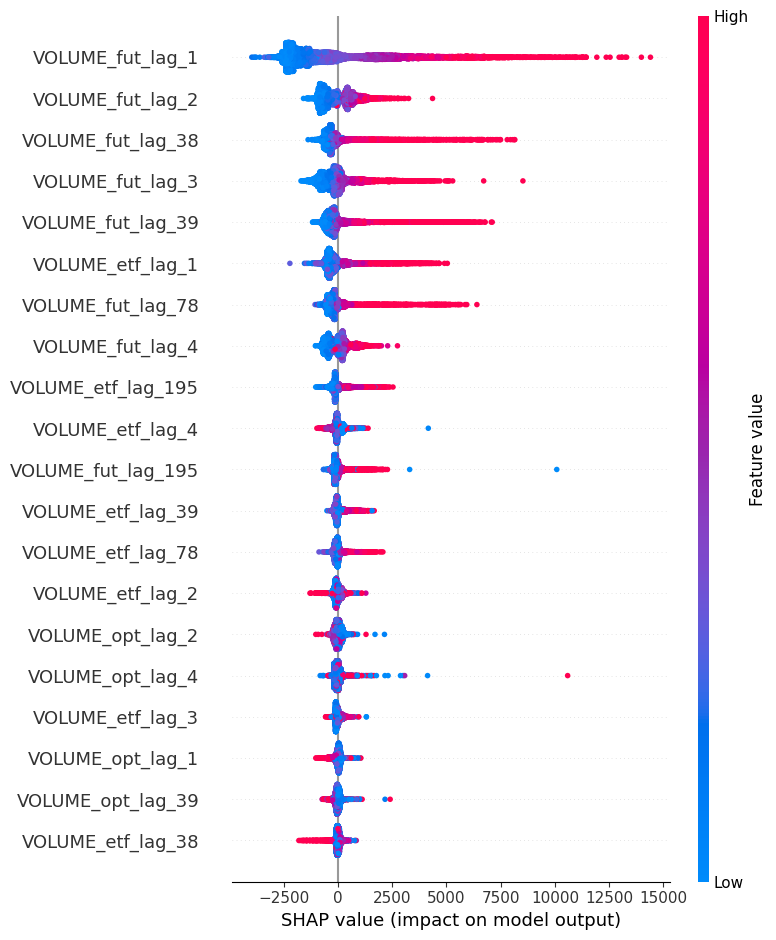

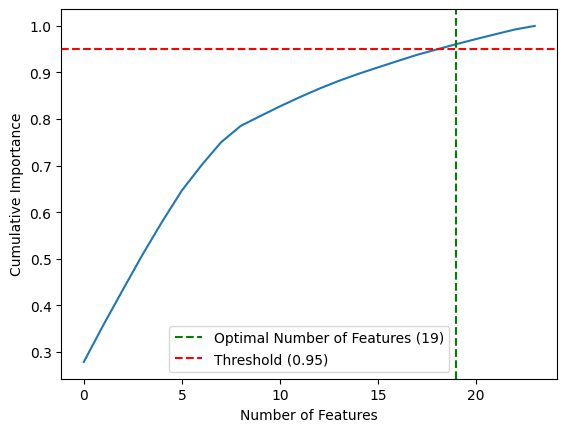

In [6]:
top_features = evaluate_feature_importance(
    df, train_indexes, lags_columns, TARGET, threshold=0.95, plot=PLOT_CHARTS
)

# Training

In [7]:
if not REMOVE_SEASONALITY:
    top_features = list(top_features) + ["hhmm"]
x_train, x_val, x_test = df.loc[train_indexes, top_features], df.loc[val_indexes, top_features], df.loc[test_indexes, top_features]
y_train, y_val, y_test = df.loc[train_indexes, TARGET], df.loc[val_indexes, TARGET], df.loc[test_indexes, TARGET]
metrics = {}

## Baseline Model

In [8]:
df = ts.copy()
df['VOLUME_fut_pred'] = df[TARGET].shift(1)

if REMOVE_SEASONALITY:
    df = restore_seasonality_ia(df)
else:
    df.loc[df['hhmm']==940, 'VOLUME_fut_pred'] = df.loc[df['hhmm']==940, TARGET].shift(1)
    df.loc[df['hhmm']==1600, 'VOLUME_fut_pred'] = df.loc[df['hhmm']==1600, TARGET].shift(1)

df_test = df.loc[test_indexes]

metrics_baseline = {"baseline": {
    'R2': r2_score(df_test[TARGET], df_test['VOLUME_fut_pred']),
    'MAE': mean_absolute_error(df_test[TARGET], df_test['VOLUME_fut_pred']),
    'MAPE': mean_absolute_percentage_error(df_test[TARGET], df_test['VOLUME_fut_pred'])
    }
}
metrics_baseline

{'baseline': {'R2': 0.632815109907548,
  'MAE': 2708.410152284264,
  'MAPE': 0.2167638107543498}}

## Simple Models

### Determine Models

In [9]:
xgb = XGBRegressor()
cat = CatBoostRegressor()
cfr = CascadeForestRegressor()
dnn = KerasRegressor(
    model=dnn,
    loss='mean_squared_error',
    optimizer='adam',
    # TODO: remove parameters below from here
    hid_layers_num=2,
    neurons_num_layer1=4,
    activation_layer1='relu',
    dropout_layer1=0,
    neurons_num_layer2=4,
    activation_layer2='relu',
    dropout_layer2=0,
    batch_size=32,
    epochs=3,
    verbose=0,
    random_seed=42,
)

### Models Parameters

In [10]:
models = {
    'xgboost': {
        'class': xgb, 
        'init_params': {
            'n_estimators': [100], 
            'max_depth': [3, 4], 
            'learning_rate': [0.1], 
            'verbosity': [0],
            'n_jobs': [4],
            'random_state': [42]
            },
        'fit_params': {'verbose': False}
        },
    'catboost': {
        'class': cat, 
        'init_params': {
            'n_estimators': [100],
            'max_depth': [3, 4],
            'learning_rate': [0.1],
            'verbose': [0],
            'thread_count': [4],
            'random_seed': [42]
            },
        'fit_params': {'verbose': False}
        },
    'cascadeforest': {
        'class': cfr,
        'init_params': {
            'n_estimators': [1, 2, 3],
            'n_trees': [100],
            'max_depth': [3, 4],
            'max_layers': [5, 10],
            'use_predictor': [False, True],
            'predictor': ["lightgbm"],
            'verbose': [0],
            'n_jobs': [4],
            'random_state': [42]
            },
        'fit_params': {}
    },
    'dnn': {
        'class': dnn,
        'init_params': {
            'hid_layers_num': [2],
            'neurons_num_layer1': [45],
            'activation_layer1': ['tanh'],
            'dropout_layer1': [0],
            'neurons_num_layer2': [45],
            'activation_layer2': ['relu'],
            'dropout_layer2': [0],
            'batch_size': [16],
            'epochs': [100],
            'verbose': [0],
            'random_seed': [42]
            },
        'fit_params': {'verbose': False}
    }
}

### Determine Metrics + Include Inverse Transform

In [11]:
# TODO: refactor code below
def custom_r2_metric(estimator, X, y_true):
    y_pred = pd.DataFrame(estimator.predict(X), index=X.index, columns=['VOLUME_fut_pred'])
    tdf_test = y_pred.join(ts)
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(tdf_test)
    r2 = r2_score(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    return r2

def custom_mape_metric(estimator, X, y_true):
    y_pred = pd.DataFrame(estimator.predict(X), index=X.index, columns=['VOLUME_fut_pred'])
    tdf_test = y_pred.join(ts)
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(tdf_test)
    mape = mean_absolute_percentage_error(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    return mape

# will use MAE as scorer (other metrics only for information)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

### GSCV

In [12]:
cv_metrics = pd.DataFrame()
sklearn_params = dict(
                scoring={
                    'MAE': mae_scorer, 
                    'R2': custom_r2_metric, 
                    'MAPE': custom_mape_metric
                },
                cv=TimeSeriesSplit(n_splits=FOLDS_NUM),
                refit='MAE',
                verbose=False,
                n_jobs=4,
            )
best_estimators = {}
for model_name, model_params in models.items():
    print(f"Training {model_name}...")
    gscv = GridSearchCV(
        model_params['class'],
        model_params['init_params'],
        **sklearn_params
    )
    gscv.fit(
        pd.concat([x_train, x_val]),
        np.ravel(pd.concat([y_train, y_val])),
        **model_params['fit_params']
    )
    
    cv_df = pd.DataFrame(gscv.cv_results_)[['params', 
                                            'mean_test_MAE', 'std_test_MAE', 
                                            'mean_test_MAPE', 'std_test_MAPE',
                                            'mean_test_R2', 'std_test_R2']]
    cv_df['mean_test_MAE'] = cv_df['mean_test_MAE'].abs()
    cv_df['model'] = model_name
    cv_metrics = pd.concat([cv_metrics, cv_df], ignore_index=True)
    print("Best mean test score:", gscv.best_score_)
    best_estimators[model_name] = gscv.best_estimator_
cv_metrics.sort_values(["mean_test_MAE"])

Training dnn...


2023-12-29 18:35:12.426835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-29 18:35:12.426856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-29 18:35:12.436527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-29 18:35:12.436548: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-29 18:35:12.487119: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

2023-12-29 18:35:15.306684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-29 18:35:15.306712: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-29 18:35:15.306730: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dev-host-1.eng.sol.onetick.com): /proc/driver/nvidia/version does not exist
2023-12-29 18:35:15.306923: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 18:35:15.337007: W tensorflow/stream_executor/platform/default/dso_loader

Best mean test score: -2287.9064510287367


,params,mean_test_MAE,std_test_MAE,mean_test_MAPE,std_test_MAPE,mean_test_R2,std_test_R2,model
5,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 16, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 45, 'neurons_num_layer2': 50, 'random_seed': 42, 'verbose': 0}",2287.906451,273.152920,0.220652,0.029844,0.765902,0.052069,dnn
8,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 16, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 50, 'neurons_num_layer2': 50, 'random_seed': 42, 'verbose': 0}",2296.077817,278.799995,0.221364,0.030877,0.764780,0.052775,dnn
4,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 16, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 45, 'neurons_num_layer2': 45, 'random_seed': 42, 'verbose': 0}",2297.633535,277.596306,0.221604,0.030397,0.763492,0.055282,dnn
7,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 16, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 50, 'neurons_num_layer2': 45, 'random_seed': 42, 'verbose': 0}",2298.272427,280.728506,0.221608,0.031299,0.763742,0.054985,dnn
2,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 16, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 40, 'neurons_num_layer2': 50, 'random_seed': 42, 'verbose': 0}",2300.011164,277.409273,0.221680,0.031048,0.762071,0.056947,dnn
1,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 16, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 40, 'neurons_num_layer2': 45, 'random_seed': 42, 'verbose': 0}",2303.785457,282.338325,0.221898,0.030665,0.761808,0.057709,dnn
6,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 16, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 50, 'neurons_num_layer2': 40, 'random_seed': 42, 'verbose': 0}",2306.087522,281.937780,0.221926,0.031362,0.761129,0.057871,dnn
3,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 16, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 45, 'neurons_num_layer2': 40, 'random_seed': 42, 'verbose': 0}",2307.929955,284.640957,0.221951,0.031558,0.759478,0.061707,dnn
0,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 16, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 40, 'neurons_num_layer2': 40, 'random_seed': 42, 'verbose': 0}",2317.679976,285.799564,0.222585,0.032247,0.755794,0.067544,dnn
14,"{'activation_layer1': 'tanh', 'activation_layer2': 'relu', 'batch_size': 32, 'dropout_layer1': 0, 'dropout_layer2': 0, 'epochs': 100, 'hid_layers_num': 2, 'neurons_num_layer1': 45, 'neurons_num_layer2': 50, 'random_seed': 42, 'verbose': 0}",2476.149965,449.988944,0.235718,0.055902,0.696390,0.184614,dnn


### Evaluation On The Test Set

In [13]:
metrics = {}
for model_name, estimator in best_estimators.items():
    y_pred = pd.DataFrame(estimator.predict(x_test), index=x_test.index, columns=['VOLUME_fut_pred'])
    tdf_test = y_pred.join(ts)
    if REMOVE_SEASONALITY:
        tdf_test = restore_seasonality_ia(tdf_test)
    
    tdf_test.dropna(inplace=True)
    r2 = r2_score(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    mae = mean_absolute_error(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    mape = mean_absolute_percentage_error(tdf_test[TARGET], tdf_test['VOLUME_fut_pred'])
    
    metrics[model_name] = {
        'R2': r2,
        'MAE': mae,
        'MAPE': mape
    }
metrics_baseline, metrics

({'baseline': {'R2': 0.632815109907548,
   'MAE': 2708.410152284264,
   'MAPE': 0.2167638107543498}},
 {'dnn': {'R2': 0.7634519571171487,
   'MAE': 2175.489236992386,
   'MAPE': 0.17770137177886083}})

### Ensemble Evaluation On The Test Set

In [14]:
y_pred = np.mean(
    [estimator.predict(x_test).flatten() for estimator in best_estimators.values()],
    axis=0,
)
y_pred = pd.DataFrame(y_pred, index=x_test.index, columns=["VOLUME_fut_pred"])
tdf_test = y_pred.join(ts)
if REMOVE_SEASONALITY:
    tdf_test = restore_seasonality_ia(tdf_test)

tdf_test.dropna(inplace=True)
r2 = r2_score(tdf_test[TARGET], tdf_test["VOLUME_fut_pred"])
mae = mean_absolute_error(tdf_test[TARGET], tdf_test["VOLUME_fut_pred"])
mape = mean_absolute_percentage_error(tdf_test[TARGET], tdf_test["VOLUME_fut_pred"])

metrics_ensemble = {"ensemble": {"R2": r2, "MAE": mae, "MAPE": mape}}
metrics_baseline, metrics, metrics_ensemble

({'baseline': {'R2': 0.632815109907548,
   'MAE': 2708.410152284264,
   'MAPE': 0.2167638107543498}},
 {'dnn': {'R2': 0.7634519571171487,
   'MAE': 2175.489236992386,
   'MAPE': 0.17770137177886083}},
 {'ensemble': {'R2': 0.7634519571171487,
   'MAE': 2175.489236992386,
   'MAPE': 0.17770137177886083}})